# Understanding E-BFMI

When I was studying a model for my disseration, a warning was displayed by Stan: E-BFMI was too low. In order to understand why it happens, [this link](https://discourse.mc-stan.org/t/issues-with-e-bfmi-missing-doc-confusing-name-etc/22553) is very useful. Moreover, [this article](https://arxiv.org/pdf/1604.00695.pdf) is very explanatory, so I will follow it in this notebook.  

Let $\pi$ be the target distribution that admits a density with respect to the Lebesgue measure. Markov chain Monte Carlo samples $x^{(1)}, x^{(2)}, \dots, x^{(n)}$ from a Markov chain that converges to the target distribution. This is a consequence of a result of convergence in Markov chains theory. In the Metropolis-Hastings algorithm, for instance, given $X_i = x$, we sample $Y$ from $P(Y = y \mid X = x) = Q(y|x)$, a propose mechanism. With probability $A(y|x)$, we accept $y$, otherwise we reject it and set $X_{i+1} = X_i$. Eventually, the Markov chain will explore the entire target distribution. The original Markov chain Monte Carlo algorithm, and one still commonly in use today, utilizes a Gaussian distribution as its proposal mechanism. 

In [1]:
import numpy as np
import pystan as ps
import matplotlib.pyplot as plt 
import arviz as az
import pickle

## Hamiltonian Monte Carlo 

We follow the [this text](https://arxiv.org/pdf/1701.02434.pdf). This method was developed in the late 1980s as Hybrid Monte Carlo to tackle calculations in Lattice Quantum Chromodynamics. Instead of moving in the parameter space randomly with uninformed jumps, the direction from the vector field given by the gradients are used to trace out a trajectory through the *typical set*, the region which has significant contribution to the expectations. However, if only the gradient was used, the trajectory would pull towards the mode of the distribution, so more geometric constraints are needed. In order to a satellite rotate around the Earth, we have to endow ir with enough momentum to counteract the gravitational field, turning the system into a conservative one. 

First, we introduce auxiliary momentum parameters $p_n$ (lift) of the same dimension from the parameter space $\Omega \subseteq \mathbb{R}^D$. Then $q_n$ turns to $(q_n, p_n)$, with the use the joint probability distribution $\pi(q,p) = \pi(p\mid q)\pi(q)$. Particularly, we use 

$$
\pi(q,p) = e^{-H(q,p)}, 
$$

such that $H$ is the *Hamiltonian*. Note that $H(q,p) = -\log \pi(p\mid q) - \log \pi(q) =: K(p,q) + V(q)$. We call $K$ the kinetic energy, and $V$ the potential energy. The vector field is generated by Hamilton's equations, 

$$
\frac{dq}{dt} = \frac{\partial H}{\partial p} = \frac{\partial K}{\partial p}
$$
$$
\frac{dp}{dt} = -\frac{\partial H}{\partial q} = -\frac{\partial K}{\partial q} - \frac{d V}{d q}.
$$

Therefore, we are able to define the Hamiltonian flows $\phi_t : (p,q) \to (p,q), \forall t \in \mathbb{R}$.

## Diagnosing Suboptimal Cotangent Desintegrations 

The cotangent desintegration is the conditional distribution over the aumentation of the parameter space.  We want to quantity the efficacy of the momentum resampling. Let $H(p,q) = E$ be the energy of the system and $\pi_{E|q}$ the distribution of $E$ induced by a momentum resampling at position $q$. The closer this this distribution is to $\pi_E$, the faster the random walk will explore the energies. The *momentum resampling* is the composition of a projection to the sample space and random lift stage. We would like that 

$$
\log \frac{d\pi_{E|q}}{d\pi_{E}} = 0, \forall q \in Q.
$$

Then we use $\mathbb{E}_{\pi}\left[\log \frac{d\pi_{E|q}}{d\pi_{E}}\right]$. One theoretically appealing choice is the Bayesian fraction of missing information

$$
BFMI = \frac{\mathbb{E}_{\pi}[Var_{\pi_{E|q}}[E\mid q]]}{Var_{\pi_{E}}[E]},
$$

which quantifies how insufficient the energy variation induced by the momentum resampling is. The basic ideia is that if the jumps between the slices of the Hamiltonian (the level sets) can be short and need more momentum.

## Hierarchical Target Example 

We will reproduce the example given in the article regarding the **eight schools posterior distribution**. It comes from [Sturtz,  Uwe Ligges, Andrew Gelman](https://www.jstatsoft.org/article/view/v012i03/v12i03.pdf)

$$
y_n \sim \operatorname{Normal}(\theta_n, \sigma_n^2), 
$$

such that 

$$
\theta_n \sim \operatorname{Normal}(\mu, \tau^2) \\
\mu \sim \operatorname{Normal}(0,10) \\
\tau \sim \operatorname{Half-C}(0,10), \\
$$

with $y_n, \sigma_n$ being the data. 

In [4]:
compiled = True
#compiled = False

if compiled: 
    sm = pickle.load(open('../models/extra/eight_schools_v0.pkl', 'rb'))
else: 
    sm = ps.StanModel(file = '../models/extra/eight_schools_v0.stan')
    with open('../models/extra/eight_schools_v0.pkl', 'wb') as f:
        pickle.dump(sm, f)

In [5]:
print(sm.model_code)

data {
    int n_samples; 
    vector[n_samples] y; 
    vector[n_samples] sigma;
}
parameters {
   real mu; 
   real<lower = 0> tau; 
   vector[n_samples] theta; 
}
model {
   mu ~ normal(0, 10);
   tau ~ cauchy(0, 10);

   for (n in 1:n_samples) {
      theta[n] ~ normal(mu, tau); 
      y[n] ~ normal(theta[n], sigma[n]);
   }
}


After compiling the model and introducing it, we include the data. 

In [6]:
data = {
    "n_samples": 8,
    "y": [28, 8, -3, 7, -1, 1, 18, 12],
    "sigma": [15, 10, 16, 11, 9, 11, 10, 18]
}

Observe below that a very simple model has problems with energy and convergence. Increasing the number of iterations can solve part of these problems, but not all.

In [7]:
%%time
fit_eight_schools_v0 = sm.sampling(data=data)
summary = az.summary(fit_eight_schools_v0)

CPU times: user 1.29 s, sys: 204 ms, total: 1.49 s
Wall time: 3.31 s


In [8]:
%%time
fit_eight_schools_v0 = sm.sampling(data=data, warmup = 5000, iter = 10000)
summary = az.summary(fit_eight_schools_v0)

CPU times: user 541 ms, sys: 55.2 ms, total: 596 ms
Wall time: 1.45 s


We could also increase `adapt_delta`. But it did not help either. I tried varying from 0.8 to 0.99, but none of them could handle this. So the problem be in the model itself. We can look at the energy plot. 

In [9]:
%%time
fit_eight_schools_v0 = sm.sampling(data=data, warmup = 5000, iter = 15000, control = {'adapt_delta': 0.99})
summary = az.summary(fit_eight_schools_v0)

CPU times: user 988 ms, sys: 174 ms, total: 1.16 s
Wall time: 10.4 s


Below we see how marginal and energy transition distributions. They are quite different, as the numerical test showed us. 

In [10]:
info = fit_eight_schools_v0.to_dataframe()

samples = {'energy': info['energy__'] - info['energy__'].mean(), 
           'tau': info['tau'], 
           'diverging': info['divergent__']}

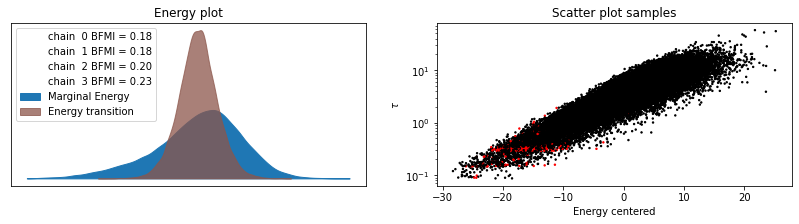

In [11]:
fig, ax = plt.subplots(1,2, figsize = (14,3))
az.plot_energy(fit_eight_schools_v0, ax = ax[0])
ax[0].set_title('Energy plot')

ax[1].scatter(samples['energy'], samples['tau'],
              color = ['k' if samples['diverging'].loc[i] == 0 else 'red' for i in range(len(samples['diverging']))], 
              s = 2)
ax[1].set_xlabel('Energy centered')
ax[1].set_ylabel(r'$\tau$')
ax[1].set_title('Scatter plot samples')
ax[1].set_yscale('log')

plt.show()

Note that the algorithm HMC was not able to fully explore the tails of the target distribution, as showed by the divergences when $\tau$ is small. Even when the step size was smaller, the exploration is incomplete. Because of that, a suggestion is to use a non-centered parametrization with indirect observation of the effects $\theta_n$. This helps with the pathological curvature of the centered distribution. The model is as follows 

$$
y_n \sim \operatorname{Normal}(\mu + \tau\tilde{\theta}_n, \sigma_n^2), 
$$

such that 

$$
\tilde{\theta}_n \sim \operatorname{Normal}(0, 1) \\
\mu \sim \operatorname{Normal}(0,10) \\
\tau \sim \operatorname{Half-C}(0,10), \\
$$

In [13]:
compiled = True
#compiled = False

if compiled: 
    sm = pickle.load(open('../models/extra/eight_schools_v1.pkl', 'rb'))
else: 
    sm = ps.StanModel(file = '../models/extra/eight_schools_v1.stan')
    with open('../models/extra/eight_schools_v1.pkl', 'wb') as f:
        pickle.dump(sm, f)

Compare the time to run this experiment without any problems. 

In [16]:
%%time
fit_eight_schools_v1 = sm.sampling(data=data, refresh = 0, warmup = 3000, iter = 4000)
summary = az.summary(fit_eight_schools_v1)

CPU times: user 211 ms, sys: 51.9 ms, total: 262 ms
Wall time: 620 ms


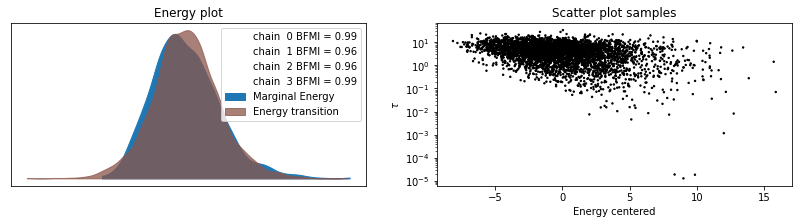

In [15]:
info = fit_eight_schools_v1.to_dataframe()

samples = {'energy': info['energy__'] - info['energy__'].mean(), 
           'tau': info['tau'], 
           'diverging': info['divergent__']}

fig, ax = plt.subplots(1,2, figsize = (14,3))
az.plot_energy(fit_eight_schools_v1, ax = ax[0])
ax[0].set_title('Energy plot')

ax[1].scatter(samples['energy'], samples['tau'],
              color = ['k' if samples['diverging'].loc[i] == 0 else 'red' for i in range(len(samples['diverging']))], 
              s = 2)
ax[1].set_xlabel('Energy centered')
ax[1].set_ylabel(r'$\tau$')
ax[1].set_title('Scatter plot samples')
ax[1].set_yscale('log')

plt.show()